<a href="https://colab.research.google.com/github/AbhinavKharde/DL-Vision-Transformer/blob/main/Covid_and_Pneumonia_varients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from zipfile import ZipFile
file_name = "/content/gdrive/MyDrive/Pneu+Corona.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
!pip install split-folders
!pip install opencv--python
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import PIL
import pathlib
import splitfolders
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_hub as hub
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
base_de_new = "/content/Pneu+Corona"
base_de_new = pathlib.Path(base_de_new)

In [ ]:
splitfolders.ratio(base_de_new, output='disease_imgs_new', seed=123, ratio=(.6,.2,.2), group_prefix=None)

Bacterial_Pneumonia = [fn for fn in os.listdir(f'{base_de_new}/Pneumonia-Bacterial') if (fn.endswith('.jpeg'))]
Corona_Virus_Disease = [fn for fn in os.listdir(f'{base_de_new}/COVID-19') if ( fn.endswith('.jpeg'))]
Normal = [fn for fn in os.listdir(f'{base_de_new}/Normal') if (fn.endswith('.jpeg'))]
Viral_Pneumonia = [fn for fn in os.listdir(f'{base_de_new}/Pneumonia-Viral') if (fn.endswith('.jpeg'))]

disease= [Bacterial_Pneumonia,Corona_Virus_Disease,Normal,Viral_Pneumonia]
disease_classes = []
for i in os.listdir('disease_imgs_new/train'):

    disease_classes +=[i]
    disease_classes.sort()

Copying files: 9208 files [00:04, 2090.37 files/s]


Total images: 9208
Total number of classes: 4
Total COVID-19 images: 3001
Total Normal images: 1281
Total Pneumonia-Bacterial images: 3270
Total Pneumonia-Viral images: 1656


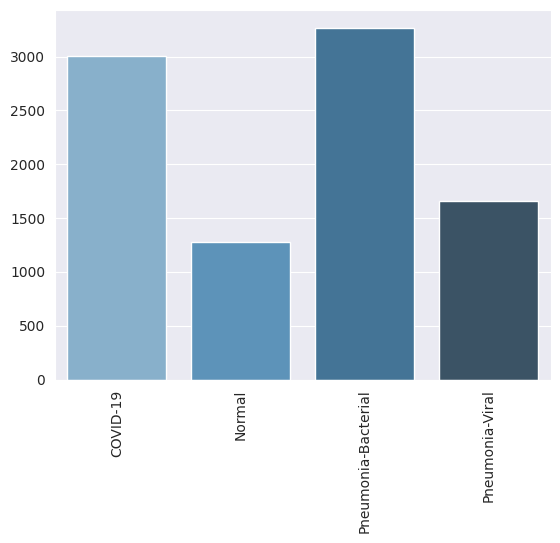

In [ ]:
# image_count1= len(list(base_de.glob('*/*.JPG')))
image_count2 = len(list(base_de_new.glob('*/*.jpeg')))
# image_count3 = len(list(base_de.glob('*/*.png')))
image_count = image_count2
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(disease_classes)}')
count = 0
disease_count = []
for x in disease_classes:

    print(f'Total {x} images: {len(disease[count])}')
    disease_count.append(len(disease[count]))
    count+=1
sns.set_style('darkgrid')
sns.barplot(x=disease_classes, y=disease_count, palette="Blues_d")
plt.xticks(rotation=90)
plt.show()

Image dimensions: (300, 400, 3)


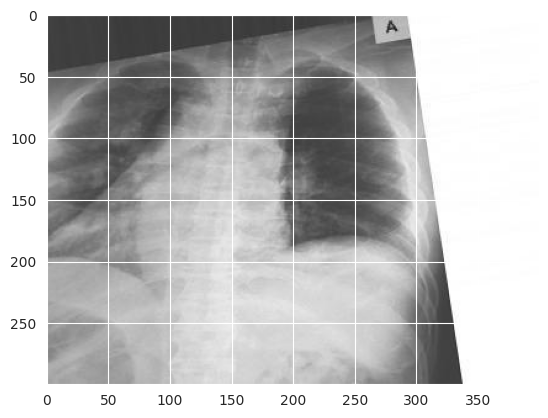

In [ ]:
sample_img = cv2.imread('/content/Pneu+Corona/COVID-19/corona_virus_disease1.jpeg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

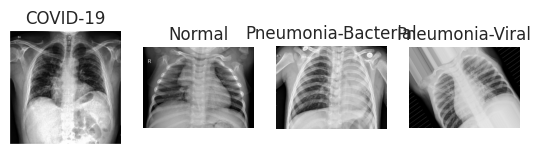

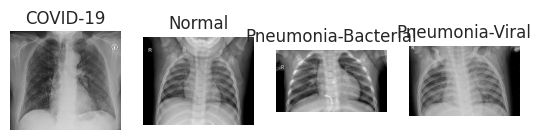

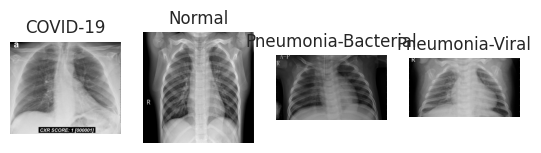

In [ ]:
def load_random_img(dir, label):
    plt.figure(figsize=(10,10))
    i=0
    for label in disease_classes:
        i+=1
        plt.subplot(1,6, i)
        file = random.choice(os.listdir(f'{dir}/{label}'))
        image_path = os.path.join(f'{dir}/{label}', file)
        img=cv2.imread(image_path)
        plt.title(label)
        plt.imshow(img)
        plt.grid(None)
        plt.axis('off')
for i in range(3):
       load_random_img(base_de_new,disease_classes)

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 100
image_size = 224 # We'll resize input images to this size
img_height, img_width = 512, 512
patch_size = 10 # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
 projection_dim * 2,
 projection_dim,
] # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] # Size of the dense layers of the final classifier

In [ ]:
train_datagen = ImageDataGenerator(
 rescale = 1./255.,
 rotation_range=30,
 zoom_range=0.15,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.15,
 horizontal_flip=True,
 fill_mode="nearest",
 )
test_datagen = ImageDataGenerator(rescale = 1./255)
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_data = image_dataset_from_directory('disease_imgs_new/train',
 label_mode = 'categorical',
 batch_size = batch_size,
 image_size = (image_size,image_size),
 shuffle = True,
 validation_split = 0.16,
 seed = 46,
 subset = 'training'
 )
test_data = image_dataset_from_directory('disease_imgs_new/test',
 label_mode = 'categorical',
 batch_size = batch_size,
 image_size = (image_size,image_size),
 shuffle = False,
 )
valid_data = image_dataset_from_directory('disease_imgs_new/val',
 label_mode = 'categorical',
 batch_size = batch_size,
 image_size = (image_size,image_size),
 shuffle = True,
 seed = 46,
 validation_split = 0.16,
 subset = 'validation'
 )


Found 5523 files belonging to 4 classes.
Using 4640 files for training.
Found 1844 files belonging to 4 classes.
Found 1841 files belonging to 4 classes.
Using 294 files for validation.


In [ ]:
data_augmentation = keras.Sequential(
 [
 layers.Normalization(),
 layers.Resizing(image_size, image_size),
 layers.RandomFlip("horizontal"),
 layers.RandomRotation(factor=0.02),
 layers.RandomZoom(
 height_factor=0.2, width_factor=0.2
 ),
 ],
 name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(train_data)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):

    def __init__(self, patch_size):
        super(Patches, self).__init__()
        super(Patches, self).__init__()
        self.patch_size = patch_size
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
import os

classes = os.listdir('/content/disease_imgs_new/train')
train_length = len(os.listdir('/content/disease_imgs_new/train/COVID-19'))
train_length,classes

(768, ['Pneumonia-Bacterial', 'COVID-19', 'Normal', 'Pneumonia-Viral'])

In [ ]:
class_names = train_data.class_names
class_names

train_dir = '/content/disease_imgs_new/train/'

Image size: 224 X 224
Patch size: 10 X 10
Patches per image: 484
Elements per patch: 300


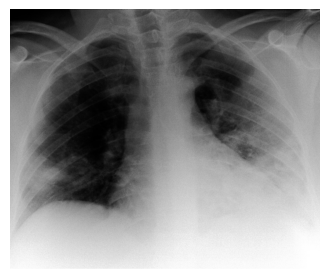

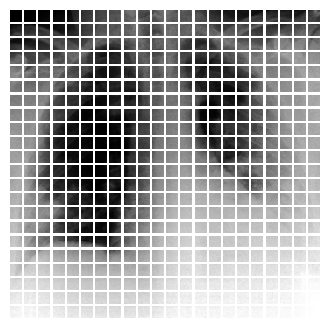

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(4, 4))
# random_class = random.choice(class_names)
target = train_dir + "COVID-19"
random_num = random.choice(os.listdir(target))
image = mpimg.imread(train_dir + "COVID-19" + "/" + random_num)
plt.imshow(image.astype("uint8"))
plt.axis("off")
resized_image = tf.image.resize(
 tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):

    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):

    def __init__(self, num_patches, projection_dim):

        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
        )
    def call(self, patch):

        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():

    inputs = layers.Input(shape=(image_size,image_size,3))
# Augment data.
    augmented = data_augmentation(inputs,training = True)
# Create patches.
    patches = Patches(patch_size)(augmented)
# Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
# Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):

# Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
# Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
         num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
# Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
# Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
# MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
# Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
# Create a [batch_size, projection_dim] tensor.
        representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation = layers.Flatten()(representation)
        representation = layers.Dropout(0.5)(representation)
# Add MLP.
        features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
# Classify outputs.
        logits = layers.Dense(len(class_names))(features)
# Create the Keras model.
        model = keras.Model(inputs=inputs, outputs=logits)
        return model

In [ ]:
import datetime
import os

def create_tensorboard_callbacks(dir,model_no):
    log_dir1 = dir + model_no + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir1 = dir + model_no + datetime.datetime.now().strftime( )
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir1=log_dir1, histogram_freq=1)
    return tensorboard_callback


feature_extractor_layer = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_r50_l32_fe/1",
                                 input_shape = (224,224,3),
                                 trainable = False,
                                 name = "Pre_trained")


model_2 = tf.keras.Sequential([
                              feature_extractor_layer,
                              layers.Dense(4,activation='softmax')
],name = "Model_2")
model_2.summary()

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Pre_trained (KerasLayer)    (None, 1024)              327969856 
                                                                 
 dense (Dense)               (None, 4)                 4100      
                                                                 
Total params: 327,973,956
Trainable params: 4,100
Non-trainable params: 327,969,856
_________________________________________________________________


In [ ]:
random.seed(50)

model_2.compile(
 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
 optimizer = tfa.optimizers.AdamW(weight_decay = 0.0001,
                                  learning_rate = 0.001),
                                  metrics = ['accuracy'])
history_1 = model_2.fit(
 train_data ,
 epochs=20,
 validation_data = valid_data
 )

Epoch 1/20
73/73 [==============================] - 74s 841ms/step - loss: 0.1856 - accuracy: 0.9250 - val_loss: 0.2798 - val_accuracy: 0.8980
Epoch 2/20
73/73 [==============================] - 61s 807ms/step - loss: 0.1807 - accuracy: 0.9306 - val_loss: 0.3154 - val_accuracy: 0.8878
Epoch 3/20
73/73 [==============================] - 61s 814ms/step - loss: 0.1842 - accuracy: 0.9289 - val_loss: 0.2523 - val_accuracy: 0.9014
Epoch 4/20
73/73 [==============================] - 60s 796ms/step - loss: 0.1816 - accuracy: 0.9295 - val_loss: 0.2627 - val_accuracy: 0.8912
Epoch 5/20
73/73 [==============================] - 60s 799ms/step - loss: 0.1764 - accuracy: 0.9315 - val_loss: 0.2572 - val_accuracy: 0.9014
Epoch 6/20
73/73 [==============================] - 60s 792ms/step - loss: 0.1723 - accuracy: 0.9336 - val_loss: 0.3046 - val_accuracy: 0.8878
Epoch 7/20
73/73 [==============================] - 61s 796ms/step - loss: 0.1705 - accuracy: 0.9332 - val_loss: 0.2839 - val_accuracy: 0.8844

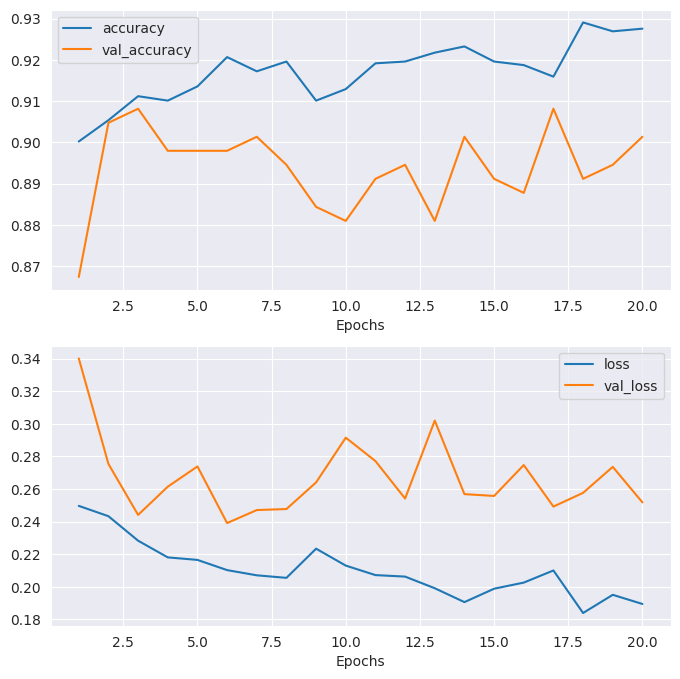

In [ ]:
import matplotlib.pyplot as plt
def plot_graph(history):

    plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    epochs=range(1,len(history.history['loss'])+1)
    plt.plot(epochs,history.history['loss'],label='loss')
    plt.plot(epochs,history.history['val_loss'],label='val_loss')
    plt.xlabel('Epochs')
# plt.title('Training vs Validation loss')
    plt.legend()
    plt.subplot(2,1,1)
    plt.plot(epochs,history.history['accuracy'],label='accuracy')
    plt.plot(epochs,history.history['val_accuracy'],label='val_accuracy')
    plt.xlabel('Epochs')
# plt.title('Training vs Validation accuracy')
    plt.legend()
plot_graph(history_1)

In [ ]:
import numpy as np
y_labels = []
for image,label in test_data.unbatch():

     y_labels.append(label.numpy().argmax())
pred_prob = model_2.predict(test_data)
preds = tf.argmax(pred_prob,axis = 1 )
print(y_labels[:10],preds[:10])

29/29 [==============================] - 25s 690ms/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] tf.Tensor([0 0 0 0 0 0 0 0 0 0], shape=(10,), dtype=int64)


In [ ]:
random.seed(50)
# vit_classifier.evaluate(test_data)
model_2.evaluate(test_data)

29/29 [==============================] - 21s 706ms/step - loss: 0.2908 - accuracy: 0.8856


[0.29076024889945984, 0.8855748176574707]